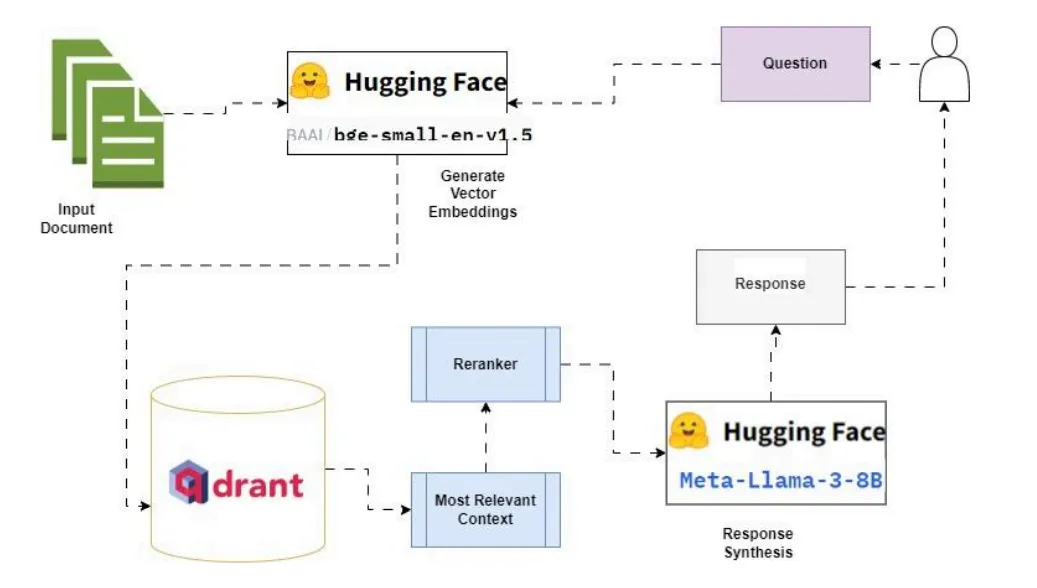

In [1]:
%%writefile requirements.txt
accelerate==0.29.3
einops==0.7.0
sentence-transformers==2.7.0
transformers==4.39.3
qdrant-client==1.9.0
llama-index==0.10.32
llama-index-agent-openai==0.2.3
llama-index-cli==0.1.12
llama-index-core==0.10.32
llama-index-embeddings-fastembed==0.1.4
llama-index-legacy==0.9.48
llama-index-llms-huggingface==0.1.4
llama-index-vector-stores-qdrant==0.2.8
qdrant-client

#

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!huggingface-cli login

In [5]:
!mkdir Data
! wget "https://arxiv.org/pdf/1810.04805.pdf" -O Data/arxiv.pdf

--2024-07-08 21:20:13--  https://arxiv.org/pdf/1810.04805.pdf
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/1810.04805 [following]
--2024-07-08 21:20:13--  http://arxiv.org/pdf/1810.04805
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775166 (757K) [application/pdf]
Saving to: ‘Data/arxiv.pdf’

Data/arxiv.pdf      100%[===================>] 757.00K  --.-KB/s    in 0.007s  

2024-07-08 21:20:13 (111 MB/s) - ‘Data/arxiv.pdf’ saved [775166/775166]



In [6]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader("/content/Data").load_data()

In [7]:
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.core  import Settings
#
embed_model = FastEmbedEmbedding(model_name="BAAI/bge-small-en-v1.5")
#
Settings.embed_model = embed_model
#
Settings.chunk_size = 512
#

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

In [8]:
from llama_index.core import PromptTemplate
system_prompt = """You are a Q&A assistant. Your goal is to answer questions as accurately as possible based on
the instructions and context provided."""
# This will wrap the default prompts that are internal to llama-index
query_wrapper_prompt = PromptTemplate("<|USER|>{query_str}<|ASSISTANT|>")

In [9]:
import torch
from transformers import AutoModelForCausalLM,AutoTokenizer
from llama_index.llms.huggingface import HuggingFaceLLM

tokenizer = AutoTokenizer.from_pretrained( "meta-llama/Meta-Llama-3-8B-Instruct")

stopping_ids = [tokenizer.eos_token_id,tokenizer.convert_tokens_to_ids("<|eot_id|>"),]
llm = HuggingFaceLLM(context_window=8192,max_new_tokens=256,generate_kwargs={"temperature": 0.7, "do_sample":False},
system_prompt=system_prompt,
query_wrapper_prompt=query_wrapper_prompt,
tokenizer_name="meta-llama/Meta-Llama-3-8B-Instruct",
model_name="meta-llama/Meta-Llama-3-8B-Instruct",
device_map="auto",
stopping_ids=stopping_ids,
tokenizer_kwargs={"max_length": 4096},
# uncomment this if using CUDA to reduce memory
model_kwargs={"torch_dtype": torch.float16})


Settings.llm = llm
Settings.chunk_size = 512

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
from IPython.display import Markdown, display
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
#
client = QdrantClient(
# you can use :memory: mode for fast and light-weight experiments,
# it does not require to have Qdrant deployed anywhere
# but requires qdrant-client >= 1.1.1
location=":memory:"
# otherwise set Qdrant instance address with:
# url="http://<host>:<port>"
# otherwise set Qdrant instance with host and port:
#host="localhost",
#port=6333
# set API KEY for Qdrant Cloud
#api_key=<YOUR API KEY>
)

vector_store = QdrantVectorStore(client=client,collection_name="test")
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(documents,storage_context=storage_context,)

In [11]:
from llama_index.core.postprocessor import SentenceTransformerRerank
rerank = SentenceTransformerRerank( model="cross-encoder/ms-marco-MiniLM-L-2-v2", top_n=3)

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
import time
query_engine = index.as_query_engine(similarity_top_k=10, node_postprocessors=[rerank] )

In [13]:
now = time.time()
response = query_engine.query("What is instruction finetuning?",)
print(f"Response Generated: {response}")
print(f"Elapsed: {round(time.time() - now, 2)}s")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Response Generated:  Instruction fine-tuning is not explicitly mentioned in the provided context. However, based on the text, it can be inferred that fine-tuning is a process where a pre-trained model like BERT is adapted to a specific task by swapping out the appropriate inputs and outputs. This process is described as "straightforward" and allows BERT to model many downstream tasks by fine-tuning all the parameters end-to-end.
Elapsed: 80.24s


credits : https://nayakpplaban.medium.com/build-an-advanced-reranking-rag-system-using-llama-index-llama-3-and-qdrant-a8b8654174bc